In [1]:
import numpy as np
from scipy.special import erf, erfinv
from matplotlib import colormaps
import matplotlib.pyplot as plt
from models import *
from train_funcs import *
from visualization import *
rng = np.random.default_rng()

In [2]:
NE, NI, N_syl, N_HVC_per_syl = 600, 150, 1, 1
N_HVC = N_syl * N_HVC_per_syl

In [3]:
peak_rate, kernel_width = 150, 50

In [4]:
T_rend = kernel_width # Each rendition
N_rend = 100 # Number of renditions
T_burn = 500 # Burning
T = T_burn + N_rend * T_rend # Total

In [5]:
# Syllables and time stamps
# ( Number of syllables , Number of renditions )
_ = np.arange(0, T - T_burn + T_rend, T_rend) # start and end time of each rendition
# start and end time of each syllabus; inter-rendition interval = duration of a syllabus
_ = np.linspace(_[:-1], _[1:], num=N_syl+1, endpoint=True) + T_burn
tsyl_start, tsyl_end = _[:-1], _[1:]
tsyl_start, tsyl_end = np.round(tsyl_start), np.round(tsyl_end)

syl = rng.normal(1, 2, size=(N_syl, NE))#.clip(min=0)
syl_rand = syl.copy()
rng.shuffle(syl_rand, axis=1)
save_W_ts = np.round(tsyl_end[-1,:-1]).astype(int)

In [6]:
rH = np.zeros((T, N_HVC))
for i in range(N_HVC):
    bt = (tsyl_start[0] + i * kernel_width).astype(int)
    for b in bt:
        rH[b:b+kernel_width,i] = peak_rate

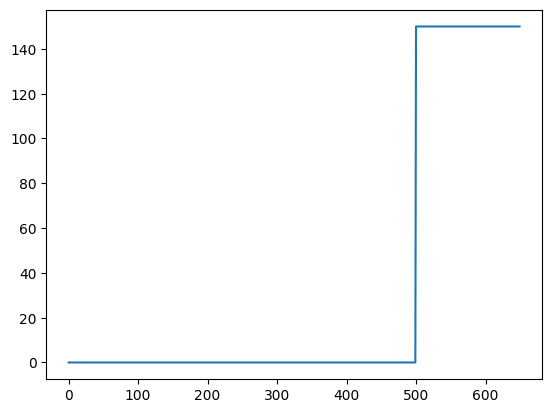

In [7]:
plt.plot(rH[:T_burn+T_rend*3])

In [8]:
# (T, NE)
aud = generate_discrete_aud(T, NE, tsyl_start, tsyl_end, syl)

In [12]:
rEmax, rImax, thE, thI, sE, sI = 50, 100, -4, 0, 2, 2
phiE = lambda x: rEmax/2 * (1 + erf((x - thE) / (np.sqrt(2) * sE)))
phiI = lambda x: rImax/2 * (1 + erf((x - thI) / (np.sqrt(2) * sI)))

def quick_net(gamma, w0_mean, w_inh, 
              JEE0=1, JEI0=1.7, JIE0=1.2, JII0=1.8, wI=0, tauE=30, tauI=10):
    gen = lognormal_gen
    # gen = const_gen
    c = 1
    sEE, sEI, sIE, sII = np.array([JEE0, JEI0, JIE0, JII0]) * gamma
    # sEE *= 1.3
    JEE = generate_matrix(NE, NE, gen, c, rng=rng, mean=JEE0, std=sEE) / np.sqrt(NE)
    JEI = generate_matrix(NE, NI, gen, c, rng=rng, mean=JEI0, std=sEI) / np.sqrt(NI)
    JIE = generate_matrix(NI, NE, gen, c, rng=rng, mean=JIE0, std=sIE) / np.sqrt(NE)
    JII = generate_matrix(NI, NI, gen, c, rng=rng, mean=JII0, std=sII) / np.sqrt(NI)

    net = EINet(NE, NI, N_HVC, w0_mean, phiE, phiI, tauE, tauI, w0_std=w0_mean/2,
                JEE=JEE, JEI=JEI, JIE=JIE, JII=JII, w_inh=w_inh, wI=wI)
    return net

In [ ]:
plasticity_kwargs = dict(plasticity=dict(HVC=bilin_hebb_E_HVC), 
                         lr=dict(HVC=-8e-2), tauW=1e5, asyn_H=0, rE_th=1)
dt = 1
hE0 = rng.normal(loc=-10, scale=0.5, size=NE)
hI0 = rng.normal(loc=-1, scale=0.5, size=NI)

In [14]:
w0_mean = 0.1/N_HVC
w_inh = w0_mean
net_fp = quick_net(0.1, w0_mean, w_inh)
net_lc = quick_net(0.3, w0_mean, w_inh)

In [15]:
train_fp = net_fp.sim(hE0, hI0, rH, aud, save_W_ts, T, dt, 0, **plasticity_kwargs)

100%|█████████████████████████████████████| 1999/1999 [00:00<00:00, 4929.48it/s]


In [15]:
train_lc = net_lc.sim(hE0, hI0, rH, aud, save_W_ts, T, dt, 0, **plasticity_kwargs)

100%|█████████████████████████████████████| 1999/1999 [00:00<00:00, 4929.48it/s]


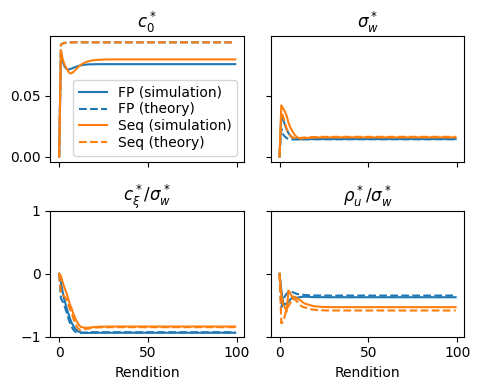

In [17]:
fig, ax = plt.subplots(2, 2, figsize=(5, 4), sharex='all', sharey='row')

ti = int(tsyl_start[0,0]) # when to start

for k, (tr, l) in enumerate(zip((train_fp, train_lc), ('FP', 'Seq'))):
    c0_lhs, c0_rhs = [0], [0]
    sig_w_lhs, sig_w_rhs = [0], [0]
    corr_u_lhs, corr_u_rhs = [0], [0]
    corr_xi_lhs, corr_xi_rhs = [0], [0]
    for i, W in enumerate(tr[2][1:]):
        t_star = int(tsyl_end[0,i] - 5 - 1) # the last of tsyl_end is len so -1
        sig = tr[-1][t_star].std() # noise std at t*
        
        # c0: W mean
        rE_mean = tr[0][int(tsyl_start[0,0])-50:int(tsyl_start[0,0])].mean()
        d0 = np.sqrt(2 * np.pi) * sE * (1 - rE_mean) / rEmax
        c0_lhs.append(W.mean())
        c0_rhs.append((d0 - syl.mean()) / peak_rate + w_inh)

        # sig_w: W std
        sig_w_lhs.append(W.std())
        # sig_w_rhs.append(np.sqrt((sig / peak_rate)**2 + c_xi**2))
        sig_w_rhs.append(np.sqrt(sig**2 + syl.var()) / peak_rate)
    
        # corr between W(t*) and (normalized) xi
        corr_xi_lhs.append(correlation(syl[0], W.T)[0])
        corr_xi_rhs.append(-syl[0].std() / W.std() / peak_rate)
        
        # corr between W(t*) and epsilon(t*)
        corr_u_lhs.append(correlation(tr[-1][t_star], W[:,0], dim=1))
        corr_u_rhs.append((-sig / W.std() / peak_rate).mean())

    color, l1, l2 = 'C%d' % k, l + ' (simulation)', l + ' (theory)'
    ax[0,0].plot(c0_lhs, c=color, label=l1)
    ax[0,0].plot(c0_rhs, c=color, ls='--', label=l2)
    ax[0,1].plot(sig_w_lhs, c=color, label=l1)
    ax[0,1].plot(sig_w_rhs, c=color, ls='--', label=l2)
    ax[1,0].plot(corr_xi_lhs, c=color, label=l1)
    ax[1,0].plot(corr_xi_rhs, c=color, ls='--', label=l2)
    ax[1,1].plot(corr_u_lhs, c=color, label=l1)
    ax[1,1].plot(corr_u_rhs, c=color, ls='--', label=l2)
    
ax[1,0].set(ylim=[-1, 1], xlabel='Rendition', yticks=[-1, 0, 1])
ax[1,1].set(xlabel='Rendition')
ax[0,0].set_title(r'$c^*_0$')
ax[0,1].set_title(r'$\sigma^*_w$')
ax[1,0].set_title(r'$c^*_\xi / \sigma^*_w$')
ax[1,1].set_title(r'$\rho^*_u / \sigma^*_w$') 
ax[0,0].legend(labelspacing=0.2)
fig.tight_layout()